# Estimating Treatment Effect Using Machine Learning

Welcome to the first assignment of **AI for Medical Treatment**!

You will be using different methods to evaluate the results of a [randomized control trial](https://en.wikipedia.org/wiki/Randomized_controlled_trial) (RCT).

**You will learn:**
- How to analyze data from a randomized control trial using both:
  - traditional statistical methods
  - and the more recent machine learning techniques
- Interpreting Multivariate Models
  - Quantifying treatment effect
  - Calculating baseline risk
  - Calculating predicted risk reduction
- Evaluating Treatment Effect Models
  - Comparing predicted and empirical risk reductions
  - Computing C-statistic-for-benefit
- Interpreting ML models for Treatment Effect Estimation
  - Implement T-learner

### This assignment covers the folowing topics:

- [1. Dataset](#1)
  - [1.1 Why RCT?](#1-1)
  - [1.2 Data Processing](#1-2)
      - [Exercise 1](#ex-01)
      - [Exercise 2](#ex-02)
- [2. Modeling Treatment Effect](#2)
  - [2.1 Constant Treatment Effect](#2-1)
      - [Exercise 3](#ex-03)
  - [2.2 Absolute Risk Reduction](#2-2)
      - [Exercise 4](#ex-04)
  - [2.3 Model Limitations](#2-3)
      - [Exercise 5](#ex-05)
      - [Exercise 6](#ex-06)
- [3. Evaluation Metric](#3)
  - [3.1 C-statistic-for-benefit](#3-1)
      - [Exercise 7](#ex-07)
      - [Exercise 8](#ex-08)
- [4. Machine Learning Approaches](#4)
  - [4.1 T-Learner](#4-1)
      - [Exercise 9](#ex-09)
      - [Exercise 10](#ex-10)
      - [Exercise 11](#ex-11)

## Packages

We'll first import all the packages that we need for this assignment. 


- `pandas` is what we'll use to manipulate our data
- `numpy`  is a library for mathematical and scientific operations
- `matplotlib` is a plotting library
- `sklearn` contains a lot of efficient tools for machine learning and statistical modeling
- `random` allows us to generate random numbers in python
- `lifelines` is an open-source library that implements c-statistic
- `itertools` will help us with hyperparameters searching

## Import Packages

Run the next cell to import all the necessary packages, dependencies and custom util functions.

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import random
import lifelines
import itertools

plt.rcParams['figure.figsize'] = [10, 7]

In [71]:
import keras; keras.__version__

'2.1.6'

<a name="1"></a>
## 1 Dataset
<a name="1-1"></a>
### 1.1 Why RCT?

In this assignment, we'll be examining data from an RCT, measuring the effect of a particular drug combination on colon cancer. Specifically, we'll be looking the effect of [Levamisole](https://en.wikipedia.org/wiki/Levamisole) and [Fluorouracil](https://en.wikipedia.org/wiki/Fluorouracil) on patients who have had surgery to remove their colon cancer. After surgery, the curability of the patient depends on the remaining residual cancer. In this study, it was found that this particular drug combination had a clear beneficial effect, when compared with [Chemotherapy](https://en.wikipedia.org/wiki/Chemotherapy). 
<a name="1-2"></a>
### 1.2 Data Processing
In this first section, we will load in the dataset and calculate basic statistics. Run the next cell to load the dataset. We also do some preprocessing to convert categorical features to one-hot representations.

In [72]:
data = pd.read_csv("levamisole_data.csv", index_col=0)

Let's look at our data to familiarize ourselves with the various fields. 

In [73]:
print(f"Data Dimensions: {data.shape}")
data.head()

Data Dimensions: (607, 14)


,sex,age,obstruct,perfor,adhere,nodes,node4,outcome,TRTMT,differ_2.0,differ_3.0,extent_2,extent_3,extent_4
1,1,43,0,0,0,5.0,1,1,True,1,0,0,1,0
2,1,63,0,0,0,1.0,0,0,True,1,0,0,1,0
3,0,71,0,0,1,7.0,1,1,False,1,0,1,0,0
4,0,66,1,0,0,6.0,1,1,True,1,0,0,1,0
5,1,69,0,0,0,22.0,1,1,False,1,0,0,1,0


Below is a description of all the fields (one-hot means a different field for each level):
- `sex (binary): 1 if Male, 0 otherwise`
- `age (int): age of patient at start of the study`
- `obstruct (binary): obstruction of colon by tumor`
- `perfor (binary): perforation of colon`
- `adhere (binary): adherence to nearby organs`
- `nodes (int): number of lymphnodes with detectable cancer`
- `node4 (binary): more than 4 positive lymph nodes`
- `outcome (binary): 1 if died within 5 years`
- `TRTMT (binary): treated with levamisole + fluoroucil`
- `differ (one-hot): differentiation of tumor`
- `extent (one-hot): extent of local spread`

In particular pay attention to the `TRTMT` and `outcome` columns. Our primary endpoint for our analysis will be the 5-year survival rate, which is captured in the `outcome` variable.

<a name='ex-01'></a>
### Exercise 01

Since this is an RCT, the treatment column is randomized. Let's warm up by finding what the treatment probability is.

$$p_{treatment} = \frac{n_{treatment}}{n}$$

- $n_{treatment}$ is the number of patients where `TRTMT = True`
- $n$ is the total number of patients.

In [74]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def proportion_treated(df):
    """
    Compute proportion of trial participants who have been treated

    Args:
        df (dataframe): dataframe containing trial results. Column
                      'TRTMT' is 1 if patient was treated, 0 otherwise.
  
    Returns:
        result (float): proportion of patients who were treated
    """
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    proportion = df.TRTMT.mean()
    
    ### END CODE HERE ###

    return proportion

**Test Case**

In [75]:
print("dataframe:\n")
example_df = pd.DataFrame(data =[[0, 0],
                                 [1, 1], 
                                 [1, 1],
                                 [1, 1]], columns = ['outcome', 'TRTMT'])
print(example_df)
print("\n")
treated_proportion = proportion_treated(example_df)
print(f"Proportion of patient treated: computed {treated_proportion}, expected: 0.75")

dataframe:

   outcome  TRTMT
0        0      0
1        1      1
2        1      1
3        1      1


Proportion of patient treated: computed 0.75, expected: 0.75


Next let's run it on our trial data.

In [76]:
p = proportion_treated(data)
print(f"Proportion Treated: {p} ~ {int(p*100)}%")

Proportion Treated: 0.49093904448105435 ~ 49%


<a name='ex-02'></a>
### Exercise 02

Next, we can get a preliminary sense of the results by computing the empirical 5-year death probability for the treated arm versus the control arm. 

The probability of dying for patients who received the treatment is:

$$p_{\text{treatment, death}} = \frac{n_{\text{treatment,death}}}{n_{\text{treatment}}}$$

- $n_{\text{treatment,death}}$ is the number of patients who received the treatment and died.
- $n_{\text{treatment}}$ is the number of patients who received treatment.

The probability of dying for patients in the control group (who did not received treatment) is:

$$p_{\text{control, death}} = \frac{n_{\text{control,death}}}{n_{\text{control}}}$$
- $n_{\text{control,death}}$ is the number of patients in the control group (did not receive the treatment) who died.
- $n_{\text{control}}$ is the number of patients in the control group (did not receive treatment).


In [77]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def event_rate(df):
    '''
    Compute empirical rate of death within 5 years
    for treated and untreated groups.

    Args:
        df (dataframe): dataframe containing trial results. 
                          'TRTMT' column is 1 if patient was treated, 0 otherwise. 
                            'outcome' column is 1 if patient died within 5 years, 0 otherwise.
  
    Returns:
        treated_prob (float): empirical probability of death given treatment
        untreated_prob (float): empirical probability of death given control
    '''
    
    treated_prob = 0.0
    control_prob = 0.0
        
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    treated_prob = df[df.TRTMT == 1].outcome.mean()
    control_prob = df[df.TRTMT == 0].outcome.mean()
    
    ### END CODE HERE ###

    return treated_prob, control_prob

**Test Case**

In [78]:
print("TEST CASE\ndataframe:\n")
example_df = pd.DataFrame(data =[[0, 1],
                                 [1, 1], 
                                 [1, 1],
                                 [0, 1],
                                 [1, 0],
                                 [1, 0],
                                 [1, 0],
                                 [0, 0]], columns = ['outcome', 'TRTMT'])
#print("dataframe:\n")
print(example_df)
print("\n")
treated_prob, control_prob = event_rate(example_df)
print(f"Treated 5-year death rate, expected: 0.5, got: {treated_prob:.4f}")
print(f"Control 5-year death rate, expected: 0.75, got: {control_prob:.4f}")

TEST CASE
dataframe:

   outcome  TRTMT
0        0      1
1        1      1
2        1      1
3        0      1
4        1      0
5        1      0
6        1      0
7        0      0


Treated 5-year death rate, expected: 0.5, got: 0.5000
Control 5-year death rate, expected: 0.75, got: 0.7500


Now let's try the function on the real data.

In [79]:
treated_prob, control_prob = event_rate(data)

print(f"Death rate for treated patients: {treated_prob:.4f} ~ {int(treated_prob*100)}%")
print(f"Death rate for untreated patients: {control_prob:.4f} ~ {int(control_prob*100)}%")

Death rate for treated patients: 0.3725 ~ 37%
Death rate for untreated patients: 0.4822 ~ 48%


On average, it seemed like treatment had a positive effect. 

#### Sanity checks
It's important to compute these basic summary statistics as a sanity check for more complex models later on. If they strongly disagree with these robust summaries and there isn't a good reason, then there might be a bug. 

### Train test split

We'll now try to quantify the impact more precisely using statistical models.  Before we get started fitting models to analyze the data, let's split it using the `train_test_split` function from `sklearn`. While a hold-out test set isn't required for logistic regression, it will be useful for comparing its performance to the ML models later on.

In [80]:
# As usual, split into dev and test set
from sklearn.model_selection import train_test_split
np.random.seed(18)
random.seed(1)

data = data.dropna(axis=0)
y = data.outcome
# notice we are dropping a column here. Now our total columns will be 1 less than before
X = data.drop('outcome', axis=1) 
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)

In [81]:
print(f"dev set shape: {X_dev.shape}")
print(f"test set shape: {X_test.shape}")

dev set shape: (455, 13)
test set shape: (152, 13)


<a name="2"></a>
## 2 Modeling Treatment Effect

<a name="2-1"></a>
### 2.1 Constant Treatment Effect

First, we will model the treatment effect using a standard logistic regression. If $x^{(i)}$ is the input vector, then this models the probability of death within 5 years as 
$$\sigma(\theta^T x^{(i)}) = \frac{1}{1 + exp(-\theta^T x^{(i)})},$$

where $ \theta^T x^{(i)} = \sum_{j} \theta_j x^{(i)}_j$ is an inner product. 


For example, if we have three features, $TRTMT$, $AGE$, and  $SEX$, then our probability of death would be written as: 

$$\sigma(\theta^T x^{(i)}) = \frac{1}{1 + exp(-\theta_{TRTMT} x^{(i)}_{TRTMT} - \theta_{AGE}x_{AGE}^{(i)} - \theta_{SEX}x^{(i)}_{SEX})}.$$


Another way to look at logistic regresion is as a linear model for the "logit" function, or "log odds": 

$$logit(p) = \log \left(\frac{p}{1-p} \right)= \theta^T x^{(i)}$$

- "Odds" is defined as the probability of an event divided by the probability of not having the event: $\frac{p}{1-p}$.  

- "Log odds", or "logit" function, is the natural log of the odds: $log \left(\frac{p}{1-p} \right)$

In this example, $x^{(i)}_{TRTMT}$ is the treatment variable. Therefore, $\theta_{TRTMT}$ tells you what the effect of treatment is. If $\theta_{TRTMT}$ is negative, then having treatment reduces the log-odds of death, which means death is less likely than if you did not have treatment. 

Note that this assumes a constant relative treatment effect, since the impact of treatment does not depend on any other covariates. 

Typically, a randomized control trial (RCT) will seek to establish a negative $\theta_{TRTMT}$ (because the treatment is intended to reduce risk of death), which corresponds to an odds ratio of less than 1.

An odds ratio of less than one implies the probability of death is less than the probability of surviving.

$$ \frac{p}{1-p} < 1 \rightarrow p < 1-p$$


Run the next cell to fit your logistic regression model. 

You can use the entire dev set (and do not need to reserve a separate validation set) because there is no need for hyperparameter tuning using a validation set.

In [82]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2',solver='lbfgs', max_iter=10000).fit(X_dev, y_dev)

### Calculating the Odds ratio

You are interested in finding the odds for treatment relative to the odds for the baseline.

$$ OddsRatio = \frac{Odds_{treatment}}{Odds_{baseline}}$$

where
$$Odds_{treatment} = \frac{p_{treatment}}{1-p_{treatment}}$$

and 

$$Odds_{baseline} = \frac{p_{baseline}}{1-p_{baseline}}$$

If you look at the expression

$$\log \left(\frac{p}{1-p} \right)= \theta^T x^{(i)} = \theta_{treatment} \times x_{treatment}^{(i)} + \theta_{age} \times x_{age}^{(i)} + \cdots$$

Let's just let "$\theta \times x_{age}^{(i)} + \cdots$" stand for all the other thetas and feature variables except for the treatment $\theta_{treatment}^{(i)}$, and $x_{treatment}^{(i)}$ .

#### Treatment
To denote that the patient received treatment, we set $x_{treatment}^{(i)} = 1$.  Which means the log odds for a treated patient are:

$$ log( Odds_{treatment}) = \log \left(\frac{p_{treatment}}{1-p_{treatment}} \right) = \theta_{treatment} \times 1 + \theta_{age} \times x_{age}^{(i)} + \cdots$$

To get odds from log odds, use exponentiation (raise to the power of e) to take the inverse of the natural log.

$$Odds_{treatment} = e^{log( Odds_{treatment})} = \left(\frac{p_{treatment}}{1-p_{treatment}} \right) = e^{\theta_{treatment} \times 1 + \theta_{age} \times x_{age}^{(i)} + \cdots}$$

#### Control (baseline)

Similarly, when the patient has no treatment, this is denoted by $x_{treatment}^{(i)} = 0$.  So the log odds for the untreated patient is:

$$log(Odds_{baseline}) = \log \left(\frac{p_{baseline}}{1-p_{baseline}} \right) = \theta_{treatment} \times 0 + \theta_{age} \times x_{age}^{(i)} + \cdots$$

$$ = 0 + \theta_{age} \times x_{age}^{(i)} + \cdots$$

To get odds from log odds, use exponentiation (raise to the power of e) to take the inverse of the natural log.

$$Odds_{baseline} = e^{log(Odds_{baseline})} = \left(\frac{p_{baseline}}{1-p_{baseline}} \right) = e^{0 + \theta_{age} \times x_{age}^{(i)} + \cdots}$$


#### Odds Ratio

The Odds ratio is:

$$ OddsRatio = \frac{Odds_{treatment}}{Odds_{baseline}}$$

Doing some substitution:

$$ OddsRatio = \frac{e^{\theta_{treatment} \times 1 + \theta_{age} \times x_{age}^{(i)} + \cdots}}{e^{0 + \theta_{age} \times x_{age}^{(i)} + \cdots}}$$

Notice that $e^{\theta_{age} \times x_{age}^{(i)} + \cdots}$ cancels on top and bottom, so that:

$$ OddsRatio = \frac{e^{\theta_{treatment} \times 1}}{e^{0}}$$

Since $e^{0} = 1$, This simplifies to:

$$ OddsRatio = e^{\theta_{treatment}}$$

<a name='ex-03'></a>
### Exercise 03: Extract the treatment effect

Complete the `extract_treatment_effect` function to extract $\theta_{treatment}$ and then calculate the odds ratio of treatment from the logistic regression model.

In [83]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def extract_treatment_effect(lr, data):
    theta_TRTMT = 0.0
    TRTMT_OR = 0.0
    coeffs = {data.columns[i]:lr.coef_[0][i] for i in range(len(data.columns))}
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # get the treatment coefficient
    theta_TRTMT = coeffs["TRTMT"]
    
    # calculate the Odds ratio for treatment
    TRTMT_OR = np.exp(theta_TRTMT)
    
    ### END CODE HERE ###
    return theta_TRTMT, TRTMT_OR


#### Test

In [84]:
# Test extract_treatment_effect function
theta_TRTMT, trtmt_OR = extract_treatment_effect(lr, X_dev)
print(f"Theta_TRTMT: {theta_TRTMT:.4f}")
print(f"Treatment Odds Ratio: {trtmt_OR:.4f}")

Theta_TRTMT: -0.2885
Treatment Odds Ratio: 0.7494


### Expected Output

```CPP
Theta_TRTMT: -0.2885
Treatment Odds Ratio: 0.7494
```

Based on this model, it seems that the treatment has a beneficial effect.  
- The $\theta_{treatment} = -0.29$ is a negative value, meaning that it has the effect of reducing risk of death.
- In the code above, the $OddsRatio$ is stored in the variable `TRTMT_OR`.
- The $OddsRatio = 0.75$, which is less than 1.  


You can think of the $OddsRatio$ as a factor that is multiplied to the baseline odds $Odds_{baseline}$ in order to estimate the $Odds_{treatment}$.  You can think about the Odds Ratio as a rate, converting between baseline odds and treatment odds.

$$Odds_{treatment} = OddsRatio \times Odds_{baseline}$$

In this case:

$$Odds_{treatment} = 0.75 \times Odds_{baseline}$$

So you can interpret this to mean that the treatment reduces the odds of death by $(1 - OddsRatio) = 1 - 0.75 = 0.25$, or about 25%.

You will see how well this model fits the data in the next few sections.

<a name="2-2"></a>
### 2.2 Absolute Risk Reduction

<a name='ex-04'></a>
### Exercise 4: Calculate ARR

A valuable quantity is the absolute risk reduction (ARR) of a treatment. If $p$ is the baseline probability of death, and $p_{treatment}$ is the probability of death if treated, then 
$$ARR = p_{baseline} - p_{treatment} $$

In the case of logistic regression, here is how ARR can be computed:  
Recall that the Odds Ratio is defined as:

$$OR = Odds_{treatment} / Odds_{baseline}$$

where the "odds" is the probability of the event over the probability of not having the event, or $p/(1-p)$. 

$$Odds_{trtmt} = \frac{p_{treatment}}{1- p_{treatment}}$$
and
$$Odds_{baseline} = \frac{p_{baseline}}{1- p_{baseline}}$$

In the function below, compute the predicted absolute risk reduction (ARR) given
- the odds ratio for treatment "$OR$", and
- the baseline risk of an individual $p_{baseline}$

If you get stuck, try reviewing the level 1 hints by clicking on the cell "Hints Level 1".  If you would like more help, please try viewing "Hints Level 2".

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints Level 1</b></font>
</summary>
<p>
<ul>
    <li> Using the given $p$, compute the baseline odds of death.</li>
    <li> Then, use the Odds Ratio to convert that to odds of death given treatment.</li>
    <li> Finally, convert those odds back into a probability</li>
</ul>
</p>

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints Level 2</b></font>
</summary>
<p>
<ul>
    <li> Solve for p_treatment starting with this expression: Odds_treatment = p_treatment / (1 - p_treatment).  You may want to do this on a piece of paper.</li>
</ul>
</p>

In [85]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def OR_to_ARR(p, OR):
    """
    Compute ARR for treatment for individuals given
    baseline risk and odds ratio of treatment.

    Args:
        p (float): baseline probability of risk (without treatment)
        OR (float): odds ratio of treatment versus baseline

    Returns:
        ARR (float): absolute risk reduction for treatment 
      """
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # compute baseline odds from p
    odds_baseline = p/(1-p)

    # compute odds of treatment using odds ratio
    odds_trtmt = OR*odds_baseline

    # compute new probability of death from treatment odds
    p_trtmt = odds_trtmt/(odds_trtmt+1)

    # compute ARR using treated probability and baseline probability 
    ARR = p-p_trtmt
    
    ### END CODE HERE ###
    
    return ARR

**Test Case**

In [86]:
print("TEST CASES")
test_p, test_OR = (0.75, 0.5)
print(f"baseline p: {test_p}, OR: {test_OR}")
print(f"Output: {OR_to_ARR(test_p, test_OR):.4f}, Expected: {0.15}\n")

test_p, test_OR = (0.04, 1.2)
print(f"baseline p: {test_p}, OR: {test_OR}")
print(f"Output: {OR_to_ARR(test_p, test_OR):.4f}, Expected: {-0.0076}")

TEST CASES
baseline p: 0.75, OR: 0.5
Output: 0.1500, Expected: 0.15

baseline p: 0.04, OR: 1.2
Output: -0.0076, Expected: -0.0076


#### Visualize the treatment effect as baseline risk varies

The logistic regression model assumes that treatment has a constant effect in terms of odds ratio and is independent of other covariates. 

However, this does not mean that absolute risk reduction is necessarily constant for any baseline risk $\hat{p}$. To illustrate this, we can plot absolute risk reduction as a function of baseline predicted risk $\hat{p}$. 

Run the next cell to see the relationship between ARR and baseline risk for the logistic regression model.

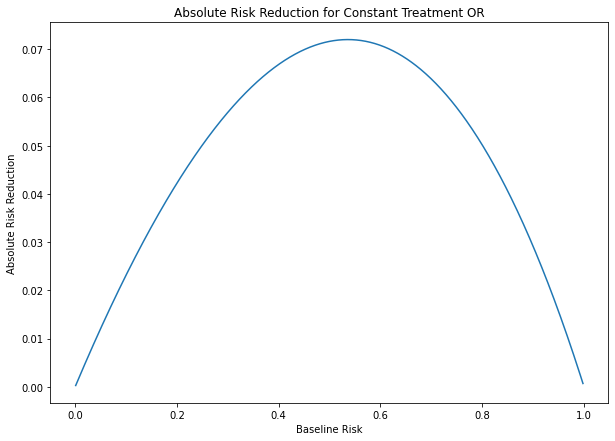

In [87]:
ps = np.arange(0.001, 0.999, 0.001)
diffs = [OR_to_ARR(p, trtmt_OR) for p in ps]
plt.plot(ps, diffs)
plt.title("Absolute Risk Reduction for Constant Treatment OR")
plt.xlabel('Baseline Risk')
plt.ylabel('Absolute Risk Reduction')
plt.show()

Note that when viewed on an absolute scale, the treatment effect is not constant, despite the fact that you used a model with no interactions between the features (we didn't multiply two features together). 

As shown in the plot, when the baseline risk is either very low (close to zero) or very high (close to one), the Absolute Risk Reduction from treatment is fairly low.  When the baseline risk is closer to 0.5 the ARR of treatment is higher (closer to 0.10).

It is always important to remember that baseline risk has a natural effect on absolute risk reduction.

<a name="2-3"></a>
### 2.3 Model Limitations

We can now plot how closely the empirical (actual) risk reduction matches the risk reduction that is predicted by the logistic regression model. 

This is complicated by the fact that for each patient, we only observe one outcome (treatment or no treatment). 
- We can't give a patient treatment, then go back in time and measure an alternative scenario where the same patient did not receive the treatment.
- Therefore, we will group patients into groups based on their baseline risk as predicted by the model, and then plot their empirical ARR within groups that have similar baseline risks.
- The empirical ARR is the death rate of the untreated patients in that group minus the death rate of the treated patients in that group.

$$ARR_{empirical} = p_{baseline} - p_{treatment}$$

<a name='ex-05'></a>
### Exercise 5: Baseline Risk
In the next cell, write a function to compute the baseline risk of each patient using the logistic regression model.

The baseline risk is the model's predicted probability that the patient is predicted to die if they do not receive treatment.

You will later use the baseline risk of each patient to organize patients into risk groups (that have similar baseline risks).  This will allow you to calculate the ARR within each risk group.

$$p_{baseline} = logisticRegression(Treatment = False, Age = age_{i}, Obstruct = obstruct_{i}, \cdots)$$

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> A patient receives treatment if their feature x_treatment is True, and does not receive treatment when their x_treatment is False.</li>
    <li>For a patient who actually did receive treatment, you can ask the model to predict their risk without receiving treatment by setting the patient's x_treatment to False.</li>
    <li>The logistic regression predict_proba() function returns a 2D array, one row for each patient, and one column for each possible outcome (each class).  In this case, the two outcomes are either no death (0), or death (1).  To find out which column contains the probability for death, check the order of the classes by using lr.classes_ </li>
</ul>
</p>

In [88]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def base_risks(X, lr_model):
    """
    Compute baseline risks for each individual in X.

    Args:
        X (dataframe): data from trial. 'TRTMT' column
                       is 1 if subject retrieved treatment, 0 otherwise
        lr_model (model): logistic regression model
    
    Returns:
        risks (np.array): array of predicted baseline risk
                          for each subject in X
    """
    
    # first make a copy of the dataframe so as not to overwrite the original
    X = X.copy(deep=True)
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # Set the treatment variable to assume that the patient did not receive treatment
    X["TRTMT"]=0
    
    # Input the features into the model, and predict the probability of death.
    risks = lr_model.predict_proba(X)[:,1]
    
    # END CODE HERE

    return risks

**Test Case**

In [89]:
example_df = pd.DataFrame(columns = X_dev.columns)
example_df.loc[0, :] = X_dev.loc[X_dev.TRTMT == 1, :].iloc[0, :]
example_df.loc[1, :] = example_df.iloc[0, :]
example_df.loc[1, 'TRTMT'] = 0

print("TEST CASE")
print(example_df)
print(example_df.loc[:, ['TRTMT']])
print('\n')

print("Base risks for both rows should be the same")
print(f"Baseline Risks: {base_risks(example_df.copy(deep=True), lr)}")

TEST CASE
  sex age obstruct perfor adhere nodes node4 TRTMT differ_2.0 differ_3.0  \
0   1  60        0      0      0     3     0  True          1          0   
1   1  60        0      0      0     3     0     0          1          0   

  extent_2 extent_3 extent_4  
0        0        1        0  
1        0        1        0  
  TRTMT
0  True
1     0


Base risks for both rows should be the same
Baseline Risks: [0.43115868 0.43115868]


#### Expected output

```CPP
Base risks for both rows should be the same
Baseline Risks: [0.43115868 0.43115868]
```

<a name='ex-06'></a>
### Exercise 6: ARR by quantile

Since the effect of treatment varies depending on the baseline risk, it makes more sense to group patients who have similar baseline risks, and then look at the outcomes of those who receive treatment versus those who do not, to estimate the absolute risk reduction (ARR).

You'll now implement the `lr_ARR_quantile` function to plot empirical average ARR for each quantile of base risk.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Use pandas.cut to define intervals of bins of equal size.  For example, pd.cut(arr,5) uses the values in the list or array 'arr' and returns the intervals of 5 bins.</li>
    <li>Use pandas.DataFrame.groupby to group by a selected column of the dataframe.  Then select the desired variable and apply an aggregator function.  For example, df.groupby('col1')['col2'].sum() groups by column 1, and then calculates the sum of column 2 for each group. </li>
</ul>
</p>


In [90]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def lr_ARR_quantile(X, y, lr):
    
    # first make a deep copy of the features dataframe to calculate the base risks
    X = X.copy(deep=True)
    
    # Make another deep copy of the features dataframe to store baseline risk, risk_group, and y
    df = X.copy(deep=True)

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # Calculate the baseline risks (use the function that you just implemented)
    baseline_risk = base_risks(X, lr)
    
    # bin patients into 10 risk groups based on their baseline risks
    risk_groups = pd.cut(baseline_risk, 10)
        
    # Store the baseline risk, risk_groups, and y into the new dataframe
    df.loc[:, 'baseline_risk'] = baseline_risk
    df.loc[:, 'risk_group'] = risk_groups
    df.loc[:, 'y'] = y

    # select the subset of patients who did not actually receive treatment
    df_baseline = df[df.TRTMT==0]
    
    # select the subset of patients who did actually receive treatment
    df_treatment = df[df.TRTMT==1]
    
    # For baseline patients, group them by risk group, select their outcome 'y', and take the mean
    baseline_mean_by_risk_group = df_baseline.groupby('risk_group')['y'].mean()
    
    # For treatment patients, group them by risk group, select their outcome 'y', and take the mean
    treatment_mean_by_risk_group = df_treatment.groupby('risk_group')['y'].mean()
    
    # Calculate the absolute risk reduction by risk group (baseline minus treatment)
    arr_by_risk_group = baseline_mean_by_risk_group - treatment_mean_by_risk_group
    
    # Set the index of the arr_by_risk_group dataframe to the average baseline risk of each risk group 
    # Use data for all patients to calculate the average baseline risk, grouped by risk group.
    arr_by_risk_group.index = df.groupby('risk_group')['baseline_risk'].mean()

    ### END CODE HERE ###
    
    # Set the name of the Series to 'ARR'
    arr_by_risk_group.name = 'ARR'
    

    return arr_by_risk_group


In [91]:
# Test
abs_risks = lr_ARR_quantile(X_dev, y_dev, lr)

# print the Series
print(abs_risks)

# just showing this as a Dataframe for easier viewing
display(pd.DataFrame(abs_risks))

baseline_risk
0.231595    0.089744
0.314713    0.042857
0.386342   -0.014604
0.458883    0.122222
0.530568    0.142857
0.626937   -0.104072
0.693404    0.150000
0.777353    0.293706
0.836617    0.083333
0.918884    0.200000
Name: ARR, dtype: float64


,ARR
baseline_risk,
0.231595,0.089744
0.314713,0.042857
0.386342,-0.014604
0.458883,0.122222
0.530568,0.142857
0.626937,-0.104072
0.693404,0.150000
0.777353,0.293706
0.836617,0.083333


##### Expected output
```CPP
baseline_risk
0.231595    0.089744
0.314713    0.042857
0.386342   -0.014604
0.458883    0.122222
0.530568    0.142857
0.626937   -0.104072
0.693404    0.150000
0.777353    0.293706
0.836617    0.083333
0.918884    0.200000
Name: ARR, dtype: float64
```

Plot the ARR grouped by baseline risk

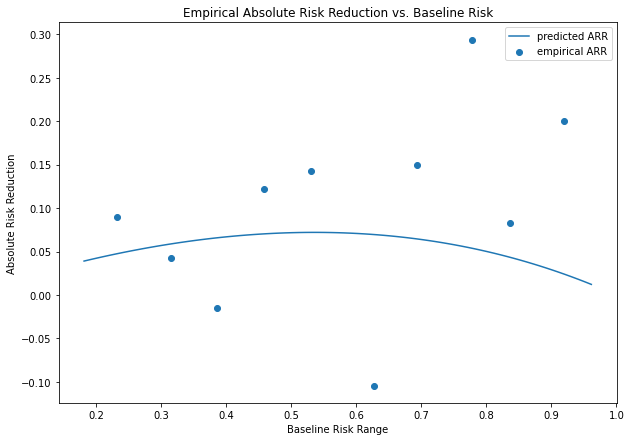

In [92]:
plt.scatter(abs_risks.index, abs_risks, label='empirical ARR')
plt.title("Empirical Absolute Risk Reduction vs. Baseline Risk")
plt.ylabel("Absolute Risk Reduction")
plt.xlabel("Baseline Risk Range")
ps = np.arange(abs_risks.index[0]-0.05, abs_risks.index[-1]+0.05, 0.01)
diffs = [OR_to_ARR(p, trtmt_OR) for p in ps]
plt.plot(ps, diffs, label='predicted ARR')
plt.legend(loc='upper right')
plt.show()

In the plot, the empirical absolute risk reduction is shown as circles, whereas the predicted risk reduction from the logistic regression model is given by the solid line.

If ARR depended only on baseline risk, then if we plotted actual (empirical) ARR grouped by baseline risk, then it would follow the model's predictions closely (the dots would be near the line in most cases).

However, you can see that the empirical absolute risk reduction (shown as circles) does not match the predicted risk reduction from the logistic regression model (given by the solid line). 

This may indicate that ARR may depend on more than simply the baseline risk.  

<a name="3"></a>
## 3 Evaluation Metric

<a name="3-1"></a>
### 3.1 C-statistic-for-benefit (C-for-benefit)

You'll now use a measure to evaluate the discriminative power of your models for predicting ARR. Ideally, you could use something like the regular Concordance index (also called C-statistic) from Course 2. Proceeding by analogy, you'd like to estimate something like:

$$P(A \text{ has higher predicted ARR than } B| A \text{ experienced a greater risk reduction than } B).$$


#### The ideal data cannot be observed

The fundamental problem is that for each person, you can only observe either their treatment outcome or their baseline outcome. 
- The patient either receives the treatment, or does not receive the treatment.  You can't go back in time to have the same patient undergo treatment and then not have treatment.
- This means that you can't determine what their actual risk reduction was. 

#### Estimate the treated/untreated patient using a pair of patients

What you will do instead is match people across treatment and control arms based on predicted ARR. 
- Now, in each pair, you'll observe both outcomes, so you'll have an estimate of the true treatment effect.
- In the pair of patients (A,B), 
    - Patient A receives the treatment 
    - Patient B does not receive the treatment.
- Think of the pair of patients as a substitute for the the ideal data that has the same exact patient in both the treatment and control group.

#### The C-for-benefit

$$P(\text{$P_1$ has a predicted ARR greater than $P_2$} | \text{$P_1$ experiences greater risk reduction than $P_2$}),$$

- Pair 1 consists of two patients (A,B), where A receives treatment, B does not.
- Pair 2 is another pair of two patients (A,B), where A receives treatment, B does not.

The risk reduction for each pair is:
- 1 if the treated person A survives and the untreated B person does not (treatment helps).  
- -1 if the treated person A dies and the untreated person B doesn't (treatment harms)
- 0 otherwise (treatment has no effect, because both patients in the pair live, or both die).

#### Details for calculating C-for-benefit

The c-for-benefit gives you a way to evaluate the ability of models to discriminate between patient profiles which are likely to experience greater benefit from treatment. 
- If you are better able to predict how likely a treatment can improve a patient's outcome, you can help the doctor and patient make a more informed decision when deciding whether to undergo treatment, considering the possible side-effects and other risks associated with treatment.

Please complete the implementation of the C-statistic-for-benefit below.  

The code to create the pairs is given to you. 
```CPP
obs_benefit_dict = {
        (0, 0): 0,
        (0, 1): -1,
        (1, 0): 1,
        (1, 1): 0,
    }
```
Here is the interpretation of this dictionary for a pair of patients, (A,B), where A receives treatment and B does not:  
- When patient A does not die, and neither does patient B, `(0, 0)`, the observed benefit of treatment is 0.
- When patient A does not die, but patient B does die, `(0, 1)`, the observed benefit is -1 (the treatment helped).
- When patient A dies, but patient B does not die, `(1, 0)`, the observed benefit is 1 (the treatment was harmful)
- When patient A dies and patient B dies, `(0, 0)`, the observed benefit of treatment is 0.

Each patient in the pair is represented by a tuple `(ARR, y)`.
- Index 0 contains the predicted ARR, which is the predicted benefit from treatment.
- Index 1 contains the actual patient outcome: 0 for no death, 1 for death.

So a pair of patients is represented as a tuple containing two tuples:

For example, Pair_1 is `( (ARR_1_A, y_1_A),(ARR_1_B, y_1_B))`, and the data may look like:
`( (0.60, 0),(0.40, 1))`.  
- This means that patient A (who received treatment) has a predicted benefit of 0.60 and does not die.
- Patient B (who did not receive treatment) has a predicted benefit of 0.40 and dies.

<a name='ex-07'></a>
### Exercise 7: Calculate c for benefit score
In `c_for_benefit_score`, you will compute the C-for-benefit given the matched pairs.

$$\text{c for benefit score} = \frac{concordant + 0.5 \times risk\_ties}{permissible}$$

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Click here for Hints!</b></font>
</summary>
<p>
<ul>
    <li>A pair of patients in this case are two patients whose data are used to represent a single patient.</li>
    <li> A pair of pairs is similar to what you think of as just a "pair" in the course 2 concordance index.  It's a pair of pairs of patients (four patients total).</li>
    <li>Each patient is represented by a tuple of two values.  The first value is the predicted risk reduction, and the second is the patient's outcome.</li>
    <li>observed benefit: for each patient pair, the first patient is assumed to be the one who received treatment, and second in the pair is the one who did not receive treatment.  Observed benefit is either 0 (no effect), -1 (treatment helped), 1 (treatment harmed)</li>
    <li>predicted benefit: for each patient pair, take the mean of the two predicted benefits.  This is the first value in each patient's tuple.</li>
    <li>permissible pair of pairs: observed benefit is different between the two pairs of pairs of patients.</li>
    <li>concordant pair: the observed benefit and predicted benefit of pair 1 are both less than those for pair 2; or, the observed and predicted benefit of pair 1 are both greater than those for pair 2.  Also, it should be a permissible pair of pairs.</li>
    <li>Risk tie: the predicted benefits of both pairs are equal, and it's also a permissible pair of pairs.</li>
</ul>
</p>


In [93]:
# UNQ_C7 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def c_for_benefit_score(pairs):
    """
    Compute c-statistic-for-benefit given list of
    individuals matched across treatment and control arms. 

    Args:
        pairs (list of tuples): each element of the list is a tuple of individuals,
                                the first from the control arm and the second from
                                the treatment arm. Each individual 
                                p = (pred_outcome, actual_outcome) is a tuple of
                                their predicted outcome and actual outcome.
    Result:
        cstat (float): c-statistic-for-benefit computed from pairs.
    """
    
    # mapping pair outcomes to benefit
    obs_benefit_dict = {
        (0, 0): 0,
        (0, 1): -1,
        (1, 0): 1,
        (1, 1): 0,
    }
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None', 'False', and 'pass' with your code) ###
    
    #print([(p[0][1],p[1][1]) for p in pairs])
    
    # compute observed benefit for each pair
    obs_benefit = [obs_benefit_dict[(p[0][1], p[1][1])] for p in pairs]

    # compute average predicted benefit for each pair
    pred_benefit = [np.mean([p[0][0], p[1][0]]) for p in pairs]

    concordant_count, permissible_count, risk_tie_count = 0, 0, 0

    # iterate over pairs of pairs
    for i in range(len(pairs)):
        for j in range(i + 1, len(pairs)):
            
            # if the observed benefit is different, increment permissible count
            if obs_benefit[i] != obs_benefit[j]:

                # increment count of permissible pairs
                permissible_count += 1
                
                # if concordant, increment count
                
                if (obs_benefit[i] < obs_benefit[j]) == (pred_benefit[i] < pred_benefit[j]): # change to check for concordance
                    
                    concordant_count += 1

                # if risk tie, increment count
                if (pred_benefit[i] == pred_benefit[j]): #change to check for risk ties
                    risk_tie_count += 1


    # compute c-statistic-for-benefit
    cstat = (concordant_count + 0.5 * risk_tie_count) / permissible_count
    
    # END CODE HERE
    
    return cstat

**Test Case**

In [94]:
print("TEST CASE")
tmp_pairs = [((0.64, 1), (0.54, 0)), 
             ((0.44, 0),(0.40, 1)), 
             ((0.56, 1), (0.74, 0)), 
             ((0.22,0),(0.22,1)), 
             ((0.22,1),(0.22,0))]
print(f"pairs: {tmp_pairs}")
tmp_cstat = c_for_benefit_score(tmp_pairs)
print(f"Output: {tmp_cstat:.4f}")

TEST CASE
pairs: [((0.64, 1), (0.54, 0)), ((0.44, 0), (0.4, 1)), ((0.56, 1), (0.74, 0)), ((0.22, 0), (0.22, 1)), ((0.22, 1), (0.22, 0))]
Output: 0.7500


##### Expected Output

```CPP
TEST CASE
pairs: [((0.64, 1), (0.54, 0)), ((0.44, 0), (0.4, 1)), ((0.56, 1), (0.74, 0)), ((0.22, 0), (0.22, 1)), ((0.22, 1), (0.22, 0))]
Output: 0.7500
```

<a name='ex-08'></a>
### Exercise 8: Create patient pairs and calculate c-for-benefit

You will implement the function `c_statistic`, which prepares the patient data and uses the c-for-benefit score function to calculate the c-for-benefit:

- Take as input:
    - The predicted risk reduction `pred_rr` (ARR)
    - outcomes `y` (1 for death, 0 for no death)
    - treatments `w` (1 for treatment, 0 for no treatment)
- Collect the predicted risk reduction, outcomes and treatments into tuples, one tuple for each patient.
- Filter one list of tuples where patients did not receive treatment.
- Filter another list of tuples where patients received treatment.

- Make sure that there is one treated patient for each untreated patient.
    - If there are fewer treated patients, randomly sample a subset of untreated patients, one for each treated patient.
    - If there are fewer untreated patients, randomly sample a subset of treated patients, one for each untreated patient.
    
- Sort treated patients by their predicted risk reduction, and similarly sort the untreated patients by predicted risk reduction.
    - This allows you to match the treated patient with the highest predicted risk reduction with the untreated patient with the highest predicted risk reduction.  Similarly, the second highest treated patient is matched with the second highest untreated patient.
    
- Create pairs of treated and untreated patients.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> Use zip(a,b,c) to create tuples from two or more lists of equal length, and use list(zip(a,b,c)) to store that as a list data type.</li>
    <li> Use filter(lambda x: x[0] == True, some_list) to filter a list (such as a list of tuples) so that the 0th item in each tuple is equal to True. Cast the result as a list using list(filter(lambda x: x[0] == True, some_list)) </li>
    <li>Use random.sample(some_list, sub_sample_length) to sample a subset from a list without replacement.</li>
    <li>Use sorted(some_list, key=lambda x: x[1]) to sort a list of tuples by their value in index 1.</li>
</ul>
</p>


In [ ]:
# UNQ_C8 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def c_statistic(pred_rr, y, w, random_seed=0):
    """
    Return concordance-for-benefit, the proportion of all matched pairs with
    unequal observed benefit, in which the patient pair receiving greater
    treatment benefit was predicted to do so.

    Args: 
        pred_rr (array): array of predicted risk reductions
        y (array): array of true outcomes
        w (array): array of true treatments 
    
    Returns: 
        cstat (float): calculated c-stat-for-benefit
    """
    assert len(pred_rr) == len(w) == len(y)
    random.seed(random_seed)
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # Collect pred_rr, y, and w into tuples for each patient
    tuples = None
    
    # Collect untreated patient tuples, stored as a list
    untreated = None
    
    # Collect treated patient tuples, stored as a list
    treated = None

    # randomly subsample to ensure every person is matched
    
    # if there are more untreated than treated patients,
    # randomly choose a subset of untreated patients, one for each treated patient.

    if len(treated) < len(untreated):
        untreated = None
        
    # if there are more treated than untreated patients,
    # randomly choose a subset of treated patients, one for each treated patient.
    if len(untreated) < len(treated):
        treated = None
        
    assert len(untreated) == len(treated)

    # Sort the untreated patients by their predicted risk reduction
    untreated = None
    
    # Sort the treated patients by their predicted risk reduction
    treated = None
    
    # match untreated and treated patients to create pairs together
    pairs = None

    # calculate the c-for-benefit using these pairs (use the function that you implemented earlier)
    cstat = None
    
    ### END CODE HERE ###
    
    return cstat

In [ ]:
# Test

tmp_pred_rr = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
tmp_y = [0,1,0,1,0,1,0,1,0]
tmp_w = [0,0,0,0,1,1,1,1,1]

tmp_cstat = c_statistic(tmp_pred_rr, tmp_y, tmp_w)

print(f"C-for-benefit calculated is {tmp_cstat}")

##### Expected output

```CPP
C-for-benefit calculated is 0.6
```

### Predicted risk reduction
In order to compute the c-statistic-for-benefit for any of your models, you need to compute predicted risk reduction from treatment (predicted risk reduction is the input `pred_rr` to the c-statistic function).

- The easiest way to do this in general is to create a version of the data where the treatment variable is False and a version where it is True.
- Then take the difference $\text{pred_RR} = p_{control} - p_{treatment}$

We've implemented this for you.

In [ ]:
def treatment_control(X):
    """Create treatment and control versions of data"""
    X_treatment = X.copy(deep=True)
    X_control = X.copy(deep=True)
    X_treatment.loc[:, 'TRTMT'] = 1
    X_control.loc[:, 'TRTMT'] = 0
    return X_treatment, X_control

def risk_reduction(model, data_treatment, data_control):
    """Compute predicted risk reduction for each row in data"""
    treatment_risk = model.predict_proba(data_treatment)[:, 1]
    control_risk = model.predict_proba(data_control)[:, 1]
    return control_risk - treatment_risk

Now let's compute the predicted risk reductions of the logistic regression model on the test set.

In [ ]:
X_test_treated, X_test_untreated = treatment_control(X_test)
rr_lr = risk_reduction(lr, X_test_treated, X_test_untreated)

Before we evaluate the c-statistic-for-benefit, let's look at a histogram of predicted ARR.

In [ ]:
plt.hist(rr_lr, bins='auto')
plt.title("Histogram of Predicted ARR using logistic regression")
plt.ylabel("count of patients")
plt.xlabel("ARR")
plt.show()

Note that although it predicts different absolute risk reduction, it never predicts that the treatment will adversely impact risk. This is because the odds ratio of treatment is less than 1, so the model always predicts a decrease in the baseline risk. Run the next cell to compute the c-statistic-for-benefit on the test data.

In [ ]:
tmp_cstat_test = c_statistic(rr_lr, y_test, X_test.TRTMT)
print(f"Logistic Regression evaluated by C-for-Benefit: {tmp_cstat_test:.4f}")

##### Expected Output
```CPP
Logistic Regression evaluated by C-for-Benefit: 0.5412
```

Recall that a c statistic ranges from 0 to 1, and is closer to when the model being evaluated is doing a good job with its predictions.

You can see that the model is not doing a great job of predicting risk reduction, given a c-for-benefit of around 0.54.

### Regular c-index
Let's compare this with the regular C-index which you've applied in previous assignments. Note that the regular c-statistic does not look at pairs of pairs of patients, and just compares one patient to another when evaluating the model's performance.  So the regular c-index is evaluating the model's ability to predict overall patient risk, not necessarily measuring how well the model predicts benefit from treatment.

In [ ]:
from lifelines.utils import concordance_index
tmp_regular_cindex = concordance_index(y_test, lr.predict_proba(X_test)[:, 1])
print(f"Logistic Regression evaluated by regular C-index: {tmp_regular_cindex:.4f}")

##### Expected output
```CPP
Logistic Regression evaluated by regular C-index: 0.7785
```

You can see that even though the model accurately predicts overall risk (regular c-index), it does not necessarily do a great job predicting benefit from treatment (c-for-benefit). 

You can also visually assess the discriminative ability of the model by checking if the people it thinks benefit the most from treatment empirically (actually) experience a benefit. 

Since you don't have counterfactual results from individuals, you'll need to aggregate patient information in some way. 

You can group patients by deciles (10 groups) of risk.

In [ ]:
def quantile_benefit(X, y, arr_hat):
    df = X.copy(deep=True)
    df.loc[:, 'y'] = y
    df.loc[:, 'benefit'] = arr_hat
    benefit_groups = pd.qcut(arr_hat, 10)
    df.loc[:, 'benefit_groups'] = benefit_groups
    empirical_benefit = df.loc[df.TRTMT == 0, :].groupby('benefit_groups').y.mean() - df.loc[df.TRTMT == 1].groupby('benefit_groups').y.mean()
    avg_benefit = df.loc[df.TRTMT == 0, :].y.mean() - df.loc[df.TRTMT==1, :].y.mean()
    return empirical_benefit, avg_benefit

def plot_empirical_risk_reduction(emp_benefit, av_benefit, model):
    plt.scatter(range(len(emp_benefit)), emp_benefit)
    plt.xticks(range(len(emp_benefit)), range(1, len(emp_benefit) + 1))
    plt.title("Empirical Risk Reduction vs. Predicted ({})".format(model))
    plt.ylabel("Empirical Risk Reduction")
    plt.xlabel("Predicted Risk Reduction Quantile")
    plt.plot(range(10), [av_benefit]*10, linestyle='--', label='average RR')
    plt.legend(loc='lower right')
    plt.show()

emp_benefit, avg_benefit = quantile_benefit(X_test, y_test, rr_lr)
plot_empirical_risk_reduction(emp_benefit, avg_benefit, "Logistic Regression")

If the model performed well, then you would see patients in the higher deciles of predicted risk reduction (on the right) also have higher empirical risk reduction (to the top).  

This model using logistic regression is far from perfect. 

Below, you'll see if you can do better using a more flexible machine learning approach.

<a name="4"></a>
## 4 Machine Learning Approaches 

<a name="4-1"></a>
### 4.1 T-Learner

Now you will see how recent machine learning approaches compare to the more standard analysis. The approach we'll look at is called [T-learner](https://arxiv.org/pdf/1706.03461.pdf).
- "T" stands for "two". 
- The T-learner learns two different models, one for treatment risk, and another model for control risk.
- Then takes the difference of the two risk predictions to predict the risk reduction.


<a name='ex-09'></a>
### Exercise 9: Complete the TLearner class.  

- The constructor `__init__()` sets the treatment and control estimators based on the given inputs to the constructor.
- The `predict` function takes the features and uses each estimator to predict the risk of death.  Then it calculates the risk of death for the control estimator minus the risk of death from the treatment estimator, and returns this as the predicted risk reduction.

In [ ]:
# UNQ_C9 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
class TLearner():
    """
    T-Learner class.

    Attributes:
      treatment_estimator (object): fitted model for treatment outcome
      control_estimator (object): fitted model for control outcome
    """                               
    def __init__(self, treatment_estimator, control_estimator):
        """
        Initializer for TLearner class.
        """
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        # set the treatment estimator
        self.treatment_estimator = None
        
        # set the control estimator 
        self.control_estimator = None
        
        ### END CODE HERE ###

    def predict(self, X):
        """
        Return predicted risk reduction for treatment for given data matrix.

        Args:
          X (dataframe): dataframe containing features for each subject
    
        Returns:
          preds (np.array): predicted risk reduction for each row of X
        """
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        # predict the risk of death using the control estimator
        risk_control = None
        
        # predict the risk of death using the treatment estimator
        risk_treatment = None
        
        # the predicted risk reduction is control risk minus the treatment risk
        pred_risk_reduction =  risk_control - risk_treatment
        
        ### END CODE HERE ###
                
        return pred_risk_reduction

### Tune the model with grid search

In order to tune your two models, you will use grid search to find the desired parameters.
- You will use a validation set to evaluate the model on different parameters, in order to avoid overfitting to the training set.

To test models on all combinations of hyperparameters, you can first list out all of the values in a list of lists.
For example:
```CPP
hyperparams = {
    'n_estimators': [10, 20],
    'max_depth': [2, 5],
    'min_samples_leaf': [0.1, 0.2],
    'random_state': [0]
}
```
You can generate a list like this:
```CPP
[[10, 20],
 [2, 5], 
 [0.1, 0.2]
]
```

Next, you can get all combinations of the hyperparameter values:
```CPP
[(10, 2, 0.1),
 (10, 2, 0.2),
 (10, 5, 0.1),
 (10, 5, 0.2),
 (20, 2, 0.1),
 (20, 2, 0.2),
 (20, 5, 0.1),
 (20, 5, 0.2)]
```

To feed the hyperparameters into an random forest model, you can use a dictionary, so that you do not need to hard code the parameter names.
For example, instead of
```CPP
RandomForestClassifier(n_estimators= 20, max_depth=5, min_samples_leaf=0.2)
```

You have more flexibility if you create a dictionary and pass it into the model.
```CPP
args_d = {'n_estimators': 20, 'max_depth': 5, 'min_samples_leaf': 0.2}
RandomForestClassifier(**args_d)
```
This allows you to pass in a hyperparameter dictionary for any hyperpameters, not just `n_estimators`, `max_depth`, and `min_samples_leaf`.

So you'll find a way to generate a list of dictionaries, like this:
```CPP
[{'n_estimators': 10, 'max_depth': 2, 'min_samples_leaf': 0.1},
 {'n_estimators': 10, 'max_depth': 2, 'min_samples_leaf': 0.2},
 {'n_estimators': 10, 'max_depth': 5, 'min_samples_leaf': 0.1},
 {'n_estimators': 10, 'max_depth': 5, 'min_samples_leaf': 0.2},
 {'n_estimators': 20, 'max_depth': 2, 'min_samples_leaf': 0.1},
 {'n_estimators': 20, 'max_depth': 2, 'min_samples_leaf': 0.2},
 {'n_estimators': 20, 'max_depth': 5, 'min_samples_leaf': 0.1},
 {'n_estimators': 20, 'max_depth': 5, 'min_samples_leaf': 0.2}]
```

Notice how the values in both the list of tuples and list of dictionaries are in the same order as the original hyperparams dictionary.  For example, the first value in each is n_estimarors, then max_depth, and then min_samples_leaf:
```CPP
# list of lists
(10, 2, 0.1)

# list of dictionaries
{'n_estimators': 10, 'max_depth': 2, 'min_samples_leaf': 0.1}
```



Then for each dictionary of hyperparams:
- Train a model.
- Use the regular concordance index to compare their performances.  
- Identify and return the best performing model.

<a name='ex-10'></a>
### Exercise 10: hold out grid search

Implement hold out grid search.  
##### Note
In this case, you are not going to apply k-fold cross validation.  Since `sklearn.model_selection.GridSearchCV()` applies k-fold cross validation, you won't be using this to perform grid search, and you will implement your own grid search.

Please see the hints if you get stuck.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>You can use the .items() or .values() method of a dictionary to get its key, value pairs or just values.  Use a list() to store them inside a list.</li>
    <li>To get all combinations of the hyperparams, you can use itertools.product(*args_list), where args_list is a list object.</li>
    <li>To generate the list of dictionaries, loop through the list of tuples.</li>
</ul>
</p>


In [ ]:
# UNQ_C10 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def holdout_grid_search(clf, X_train_hp, y_train_hp, X_val_hp, y_val_hp, hyperparam, verbose=False):
    '''
    Conduct hyperparameter grid search on hold out validation set. Use holdout validation.
    Hyperparameters are input as a dictionary mapping each hyperparameter name to the
    range of values they should iterate over. Use the cindex function as your evaluation
    function.
    
    Input:
        clf: sklearn classifier
        X_train_hp (dataframe): dataframe for training set input variables
        y_train_hp (dataframe): dataframe for training set targets
        X_val_hp (dataframe): dataframe for validation set input variables
        y_val_hp (dataframe): dataframe for validation set targets
        hyperparam (dict): hyperparameter dictionary mapping hyperparameter
                                                names to range of values for grid search
    
    Output:
        best_estimator (sklearn classifier): fitted sklearn classifier with best performance on
                                                                                 validation set
    '''
    # Initialize best estimator
    best_estimator = None
    
    # initialize best hyperparam
    best_hyperparam = {}
    
    # initialize the c-index best score to zero
    best_score = 0.0
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # Get the values of the hyperparam and store them as a list of lists
    hyper_param_l = None
    
    # Generate a list of tuples with all possible combinations of the hyperparams
    combination_l_of_t = None
    
    # Initialize the list of dictionaries for all possible combinations of hyperparams
    combination_l_of_d = []
    
    # loop through each tuple in the list of tuples
    for val_tuple in None: # complete this line
        param_d = {}
        
        # Enumerate each key in the original hyperparams dictionary
        for i, k in None: # complete this line
            
            # add a key value pair to param_d for each value in val_tuple
            param_d[k] = None
        
        # append the param_dict to the list of dictionaries
        None
        
    
    # For each hyperparam dictionary in the list of dictionaries:
    for param_d in None: # complete this line
        
        # Set the model to the given hyperparams
        estimator = None
        
        # Train the model on the training features and labels
        None
        
        # Predict the risk of death using the validation features
        preds = None
        
        # Evaluate the model's performance using the regular concordance index
        estimator_score = None
        
        # if the model's c-index is better than the previous best:
        if None: # complete this line

            # save the new best score
            best_score = None
            
            # same the new best estimator
            best_estimator = None
            
            # save the new best hyperparams
            best_hyperparam = None
                
    ### END CODE HERE ###

    if verbose:
        print("hyperparam:")
        display(hyperparam)
        
        print("hyper_param_l")
        display(hyper_param_l)
        
        print("combination_l_of_t")
        display(combination_l_of_t)
        
        print(f"combination_l_of_d")
        display(combination_l_of_d)
        
        print(f"best_hyperparam")
        display(best_hyperparam)
        print(f"best_score: {best_score:.4f}")
        
    return best_estimator, best_hyperparam

In [ ]:
# Test
n = X_dev.shape[0]
tmp_X_train = X_dev.iloc[:int(n*0.8),:]
tmp_X_val = X_dev.iloc[int(n*0.8):,:]
tmp_y_train = y_dev[:int(n*0.8)]
tmp_y_val = y_dev[int(n*0.8):]

hyperparams = {
    'n_estimators': [10, 20],
    'max_depth': [2, 5],
    'min_samples_leaf': [0.1, 0.2],
    'random_state' : [0]
}

from sklearn.ensemble import RandomForestClassifier
control_model = holdout_grid_search(RandomForestClassifier,
                                    tmp_X_train, tmp_y_train,
                                    tmp_X_val, tmp_y_val, hyperparams, verbose=True)

T-Learner is a convenient framework because it does not restrict your choice of base learners.
- You will use random forests as the base learners, but are able to choose another model as well.

##### Expected output

```CPP
hyperparam:
{'n_estimators': [10, 20],
 'max_depth': [2, 5],
 'min_samples_leaf': [0.1, 0.2],
 'random_state': [0]}
hyper_param_l
[[10, 20], [2, 5], [0.1, 0.2], [0]]
combination_l_of_t
[(10, 2, 0.1, 0),
 (10, 2, 0.2, 0),
 (10, 5, 0.1, 0),
 (10, 5, 0.2, 0),
 (20, 2, 0.1, 0),
 (20, 2, 0.2, 0),
 (20, 5, 0.1, 0),
 (20, 5, 0.2, 0)]
combination_l_of_d
[{'n_estimators': 10,
  'max_depth': 2,
  'min_samples_leaf': 0.1,
  'random_state': 0},
 {'n_estimators': 10,
  'max_depth': 2,
  'min_samples_leaf': 0.2,
  'random_state': 0},
 {'n_estimators': 10,
  'max_depth': 5,
  'min_samples_leaf': 0.1,
  'random_state': 0},
 {'n_estimators': 10,
  'max_depth': 5,
  'min_samples_leaf': 0.2,
  'random_state': 0},
 {'n_estimators': 20,
  'max_depth': 2,
  'min_samples_leaf': 0.1,
  'random_state': 0},
 {'n_estimators': 20,
  'max_depth': 2,
  'min_samples_leaf': 0.2,
  'random_state': 0},
 {'n_estimators': 20,
  'max_depth': 5,
  'min_samples_leaf': 0.1,
  'random_state': 0},
 {'n_estimators': 20,
  'max_depth': 5,
  'min_samples_leaf': 0.2,
  'random_state': 0}]
best_hyperparam
{'n_estimators': 10,
 'max_depth': 2,
 'min_samples_leaf': 0.1,
 'random_state': 0}
best_score: 0.5928
```

<a name='ex-11'></a>
### Exercise 11: Training and validation, treatment and control splits

- Unlike logistic regression, the machine learning algorithms used for base learners will generally require hyperparameter tuning, which means that you need to split your dev set into a training and validation set. 
- You need to also split each of the training and validation sets into *treatment* and *control* groups to train the treatment and control base learners of the T-Learner.

The function below takes in a dev dataset and splits it into training and validation sets for treatment and control models, respectively. 
Complete the implementation. 

#### Note
- The input X_train and X_val have the 'TRTMT' column.  Please remove the 'TRTMT' column from the treatment and control features that the function returns.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> To drop a column, set the axis to 1 when calling pandas.DataFrame.drop(...). Axis=0 is used to drop a row by its index label)</li>
</ul>
</p>

In [ ]:
# UNQ_C11 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def treatment_dataset_split(X_train, y_train, X_val, y_val):
    """
    Separate treated and control individuals in training
    and testing sets. Remember that returned
    datasets should NOT contain the 'TRTMT' column!

    Args:
        X_train (dataframe): dataframe for subject in training set
        y_train (np.array): outcomes for each individual in X_train
        X_val (dataframe): dataframe for subjects in validation set
        y_val (np.array): outcomes for each individual in X_val
    
    Returns:
        X_treat_train (df): training set for treated subjects
        y_treat_train (np.array): labels for X_treat_train
        X_treat_val (df): validation set for treated subjects
        y_treat_val (np.array): labels for X_treat_val
        X_control_train (df): training set for control subjects
        y_control_train (np.array): labels for X_control_train
        X_control_val (np.array): validation set for control subjects
        y_control_val (np.array): labels for X_control_val
    """
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # From the training set, get features of patients who received treatment
    X_treat_train = None
    
    # drop the 'TRTMT' column
    X_treat_train = None
    
    # From the training set, get the labels of patients who received treatment
    y_treat_train = None

    # From the validation set, get the features of patients who received treatment
    X_treat_val = None
                        
    # Drop the 'TRTMT' column
    X_treat_val = None
                        
    # From the validation set, get the labels of patients who received treatment
    y_treat_val = None
                        
# --------------------------------------------------------------------------------------------
                        
    # From the training set, get the features of patients who did not received treatment
    X_control_train = None
                        
    # Drop the TRTMT column
    X_control_train = None
                        
    # From the training set, get the labels of patients who did not receive treatment
    y_control_train = None
    
    # From the validation set, get the features of patients who did not receive treatment
    X_control_val = None
    
    # drop the 'TRTMT' column
    X_control_val = None

    # From the validation set, get teh labels of patients who did not receive treatment
    y_control_val = None
    
    ### END CODE HERE ###

    return (X_treat_train, y_treat_train,
            X_treat_val, y_treat_val,
            X_control_train, y_control_train,
            X_control_val, y_control_val)

**Test Case**

In [ ]:
# Tests
example_df = pd.DataFrame(columns = ['ID', 'TRTMT'])
example_df.ID = range(100)
example_df.TRTMT = np.random.binomial(n=1, p=0.5, size=100)
treated_ids = set(example_df[example_df.TRTMT==1].ID)
example_y = example_df.TRTMT.values

example_train, example_val, example_y_train, example_y_val = train_test_split(
    example_df, example_y, test_size = 0.25, random_state=0
)


(x_treat_train, y_treat_train,
 x_treat_val, y_treat_val,
 x_control_train, y_control_train,
 x_control_val, y_control_val) = treatment_dataset_split(example_train, example_y_train,
                                                         example_val, example_y_val)

print("Tests")
pass_flag = True
pass_flag = (len(x_treat_train) + len(x_treat_val) + len(x_control_train) +
             len(x_control_val) == 100)
print(f"\nDidn't lose any subjects: {pass_flag}")
pass_flag = (("TRTMT" not in x_treat_train) and ("TRTMT" not in x_treat_val) and
             ("TRTMT" not in x_control_train) and ("TRTMT" not in x_control_val))
print(f"\nTRTMT not in any splits: {pass_flag}")
split_treated_ids = set(x_treat_train.ID).union(set(x_treat_val.ID))
pass_flag = (len(split_treated_ids.union(treated_ids)) == len(treated_ids))
print(f"\nTreated splits have all treated patients: {pass_flag}")
split_control_ids = set(x_control_train.ID).union(set(x_control_val.ID))
pass_flag = (len(split_control_ids.intersection(treated_ids)) == 0)
print(f"\nAll subjects in control split are untreated: {pass_flag}") 
pass_flag = (len(set(x_treat_train.ID).intersection(x_treat_val.ID)) == 0)
print(f"\nNo overlap between treat_train and treat_val: {pass_flag}")
pass_flag = (len(set(x_control_train.ID).intersection(x_control_val.ID)) == 0)
print(f"\nNo overlap between control_train and control_val: {pass_flag}")
print(f"\n--> Expected: All statements should be True")

You will now train a T-learner model on the patient data, and evaluate its performance using the c-for-benefit.

First, get the training and validation sets.

In [ ]:
# Import the random forest classifier to be used as the base learner
from sklearn.ensemble import RandomForestClassifier

# Split the dev data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_dev, 
                                                  y_dev, 
                                                  test_size = 0.25,
                                                  random_state = 0)

Split the training set into a treatment and control set.  
Similarly, split the validation set into a treatment and control set.

In [ ]:
# get treatment and control arms of training and validation sets
(X_treat_train, y_treat_train, 
 X_treat_val, y_treat_val,
 X_control_train, y_control_train,
 X_control_val, y_control_val) = treatment_dataset_split(X_train, y_train,
                                                         X_val, y_val)

Choose a set of hyperparameters to perform grid search and find the best model.  
- Please first use these given hyperparameters so that you can get the same c-for-benefit calculation at the end of this exercise. 
- Afterwards, we encourage you to come back and try other ranges for these hyperparameters. 

```CPP
# Given hyperparams to do grid search
hyperparams = {
    'n_estimators': [100, 200],
    'max_depth': [2, 5, 10, 40, None],
    'min_samples_leaf': [1, 0.1, 0.2],
    'random_state': [0]
}
```

In [ ]:
# hyperparameter grid (we'll use the same one for both arms for convenience)
# Note that we set random_state to zero
# in order to make the output consistent each time it's run.
hyperparams = {
    'n_estimators': [100, 200],
    'max_depth': [2, 5, 10, 40, None],
    'min_samples_leaf': [1, 0.1, 0.2],
    'random_state': [0]
}

Train the treatment base learner.  
- Perform grid search to find a random forest classifier and associated hyperparameters with the best c-index (the regular c-index).

In [ ]:
# perform grid search with the treatment data to find the best model 
treatment_model, best_hyperparam_treat  = holdout_grid_search(RandomForestClassifier,
                                      X_treat_train, y_treat_train,
                                      X_treat_val, y_treat_val, hyperparams)


Train the control base learner.

In [ ]:
# perform grid search with the control data to find the best model 
control_model, best_hyperparam_ctrl = holdout_grid_search(RandomForestClassifier,
                                    X_control_train, y_control_train,
                                    X_control_val, y_control_val, hyperparams)


Combine the treatment and control base learners into the T-learner.

In [ ]:
# Save the treatment and control models into an instance of the TLearner class
t_learner = TLearner(treatment_model, control_model)

For the validation set, predict each patient's risk reduction.

In [ ]:
# Use the t-learner to predict the risk reduction for patients in the validation set
rr_t_val = t_learner.predict(X_val.drop(['TRTMT'], axis=1))

print(f"X_val num of patients {X_val.shape[0]}")
print(f"rr_t_val num of patient predictions {rr_t_val.shape[0]}")

Now plot a histogram of your predicted risk reduction on the validation set. 

In [ ]:
plt.hist(rr_t_val, bins='auto')
plt.title("Histogram of Predicted ARR, T-Learner, validation set")
plt.xlabel('predicted risk reduction')
plt.ylabel('count of patients')
plt.show()

Notice when viewing the histogram that predicted risk reduction can be negative.
- This means that for some patients, the T-learner predicts that treatment will actually increase their risk (negative risk reduction). 
- The T-learner is more flexible compared to the logistic regression model, which only predicts non-negative risk reduction for all patients (view the earlier histogram of the 'predicted ARR' histogram for the logistic regression model, and you'll see that the possible values are all non-negative).

Now plot an empirical risk reduction plot for the validation set examples. 

In [ ]:
empirical_benefit, avg_benefit = quantile_benefit(X_val, y_val, rr_t_val)
plot_empirical_risk_reduction(empirical_benefit, avg_benefit, 'T Learner [val set]')

Recall that the predicted risk reduction is along the horizontal axis and the vertical axis is the empirical (actual risk reduction).

A good model would predict a lower risk reduction for patients with actual lower risk reduction.  Similarly, a good model would predict a higher risk reduction for patients with actual higher risk reduction (imagine a diagonal line going from the bottom left to the top right of the plot).

The T-learner seems to be doing a bit better (compared to the logistic regression model) at differentiating between the people who would benefit most treatment and the people who would benefit least from treatment.

Compute the C-statistic-for-benefit on the validation set.

In [ ]:
c_for_benefit_tlearner_val_set = c_statistic(rr_t_val, y_val, X_val.TRTMT)
print(f"C-for-benefit statistic of T-learner on val set: {c_for_benefit_tlearner_val_set:.4f}")

##### Expected output

```CPP
C-for-benefit statistic of T-learner on val set: 0.5043
```

Now or the test set, predict each patient's risk reduction

In [ ]:
# predict the risk reduction for each of the patients in the test set
rr_t_test = t_learner.predict(X_test.drop(['TRTMT'], axis=1))

Plot the histogram of risk reduction for the test set.

In [ ]:
# Plot a histogram of the predicted risk reduction
plt.hist(rr_t_test, bins='auto')
plt.title("Histogram of Predicted ARR for the T-learner on test set")
plt.xlabel("predicted risk reduction")
plt.ylabel("count of patients")
plt.show()

Plot the predicted versus empircal risk reduction for the test set.

In [ ]:
# Plot the predicted versus empirical risk reduction for the test set
empirical_benefit, avg_benefit = quantile_benefit(X_test, y_test, rr_t_test)
plot_empirical_risk_reduction(empirical_benefit, avg_benefit, 'T Learner (test set)')

Evaluate the T-learner's performance using the test set.

In [ ]:
# calculate the c-for-benefit of the t-learner on the test set
c_for_benefit_tlearner_test_set = c_statistic(rr_t_test, y_test, X_test.TRTMT)
print(f"C-for-benefit statistic on test set: {c_for_benefit_tlearner_test_set:.4f}")

##### Expected output

```CPP
C-for-benefit statistic on test set: 0.5250
```

The c-for-benefit of the two models were evaluated on different test sets.  However, we can compare their c-for-benefit scores to get a sense of how they perform:
- logistic regression: 0.5412
- T-learner: 0.5250

The T-learner doesn't actually do better than the logistic regression in this case.  You can try to tune the hyperparameters of the T-Learner to see if you can improve it.

### Note
While the more flexible ML techniques may improve predictive power, the sample size is too small to be certain. 
- Models like the T-learner could still be helpful in identifying subgroups who will likely not be helped by treatment, or could even be harmed by treatment.  
- So doctors can study these patients in more detail to find out how to improve their outcomes. 

## Congratulations

You've finished the assignment for Course 3 Module 1! We've seen that machine learning techniques can help determine when a treatment will have greater treatment effect for a particular patient.